In [153]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/shai-music-genre-classification/test (2).csv
/kaggle/input/shai-music-genre-classification/sample_submission (2).csv
/kaggle/input/shai-music-genre-classification/train (1).csv


In [154]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier




import warnings
# Ignore all warning
warnings.filterwarnings('ignore')

In [155]:
# Load the dataset: 
path_data_train = "/kaggle/input/shai-music-genre-classification/train (1).csv"
path_data_test = "/kaggle/input/shai-music-genre-classification/test (2).csv"
path_data_submission_sample = "/kaggle/input/shai-music-genre-classification/sample_submission (2).csv"
data_train = pd.read_csv(path_data_train)
data_test = pd.read_csv(path_data_test)
data_submission_sample = pd.read_csv(path_data_submission_sample)

# data_train.head(10)
# data_test.head(10)
data_submission_sample.head(10)

,Id,Class
0,14397,6
1,14398,6
2,14399,9
3,14400,10
4,14401,5
5,14402,6
6,14403,6
7,14404,9
8,14405,5
9,14406,10


In [156]:
# Mapping dictionary
label_mapping = {
    0: 'Acoustic/Folk',
    1: 'Alt_Music',
    2: 'Blues',
    3: 'Bollywood',
    4: 'Country',
    5: 'HipHop',
    6: 'Indie Alt',
    7: 'Instrumental',
    8: 'Metal',
    9: 'Pop',
    10: 'Rock'
}

In [157]:
current_datetime = datetime.now()
formatted_current_datetime = current_datetime.strftime("%Y-%m-%d_%H:%M:%S")

formatted_current_datetime

'2025-11-21_08:39:05'

# Strategy for building model

- Train: Pipeline + GridSearchCV -> Model -> Save model (pkl)
- Test: Load model --test_set--> Predict


## 1. Check unreasonable data

### 1.1 **'duration_in min/ms'**

#### a) Check 

In [158]:
# Check sample have unreasonable duration: so short | long | ...

# Convert duration_in min/ms  --> sec

data_train['duration_sec'] = data_train['duration_in min/ms'] / 1000 

# Statistic: 
print(data_train['duration_sec'].describe())

count    14396.000000
mean       200.094223
std        111.689098
min          0.000502
25%        165.445750
50%        208.941000
75%        252.247000
max       1477.187000
Name: duration_sec, dtype: float64


In [159]:
# Count number of sample have invalid duration
def checkDuration(data_train):
    n_invalid = len(data_train[data_train['duration_sec'] <= 3])
    n_short = len(data_train[(data_train['duration_sec'] > 3) & (data_train['duration_sec'] < 30)])
    n_long = len(data_train[data_train['duration_sec'] > 600])  # 10 mins
    n_extreme = len(data_train[data_train['duration_sec'] > 1800]) # 30 mins
    
    print("--- Check duration ---\n")
    print(f"Invalid: {n_invalid} - {n_invalid/len(data_train)*100}%")
    print(f"Short: {n_short} - {n_short/len(data_train)*100}%")
    print(f"Long: {n_long} - {n_long/len(data_train)*100}%")
    print(f"Extreme: {n_extreme} - {n_extreme/len(data_train)*100}%")

checkDuration(data_train)

--- Check duration ---

Invalid: 2075 - 14.413726035009725%
Short: 0 - 0.0%
Long: 62 - 0.43067518755209777%
Extreme: 0 - 0.0%


- Comment:
  + 2075 samples(14.4%) have duration_sec < 2s &rarr; **NOISE**

#### b) Handle

- Remove all samples having duration_sec < 3s

In [160]:
# data_train = data_train[data_train['duration_sec'] > 3]
# checkDuration(data_train)

df = data_train.copy()
# 1. Kiểm tra xem Class nào có toàn bài hát ngắn
print("--- Phân tích độ dài trung bình theo Class ---")
short_check = df.groupby('Class')['duration_sec'].mean()
print(short_check)

# 2. Đếm số lượng mẫu từng class trước khi xóa
print("\n--- Số lượng mẫu ban đầu ---")
print(df['Class'].value_counts())

# 3. Lọc thông minh (Conditional Drop)
# Logic: 
# - Giữ lại tất cả các bài > 3s
# - HOẶC: Giữ lại các bài <= 3s NẾU nó thuộc Class 0, 3, 4, 7 (Các class bị mất)
classes_to_keep_short = [0, 3, 4, 7] 

# Điều kiện giữ lại: (Dài > 3s) HOẶC (Là class đặc biệt)
condition = (df['duration_sec'] > 3) | (df['Class'].isin(classes_to_keep_short))

data_train_filtered = df[condition]

print(f"\nShape cũ: {df.shape}")
print(f"Shape mới: {data_train_filtered.shape}")

# Check lại xem Class 3, 4, 7 còn sống không
print("\n--- Check lại các Class sau khi lọc ---")
print(data_train_filtered['Class'].value_counts().sort_index())



--- Phân tích độ dài trung bình theo Class ---
Class
0       0.004102
1     224.334498
2     248.134235
3       0.004848
4       0.003381
5     206.552665
6     227.194831
7       0.004165
8     271.536306
9     173.034889
10    232.517454
Name: duration_sec, dtype: float64

--- Số lượng mẫu ban đầu ---
Class
10    3959
6     2069
9     2019
8     1483
5     1157
1     1098
2     1018
0      500
7      461
3      322
4      310
Name: count, dtype: int64

Shape cũ: (14396, 19)
Shape mới: (13914, 19)

--- Check lại các Class sau khi lọc ---
Class
0      500
1     1098
2     1018
3      322
4      310
5     1157
6     2069
7      461
8     1483
9     1680
10    3816
Name: count, dtype: int64


In [161]:
data_train = data_train_filtered

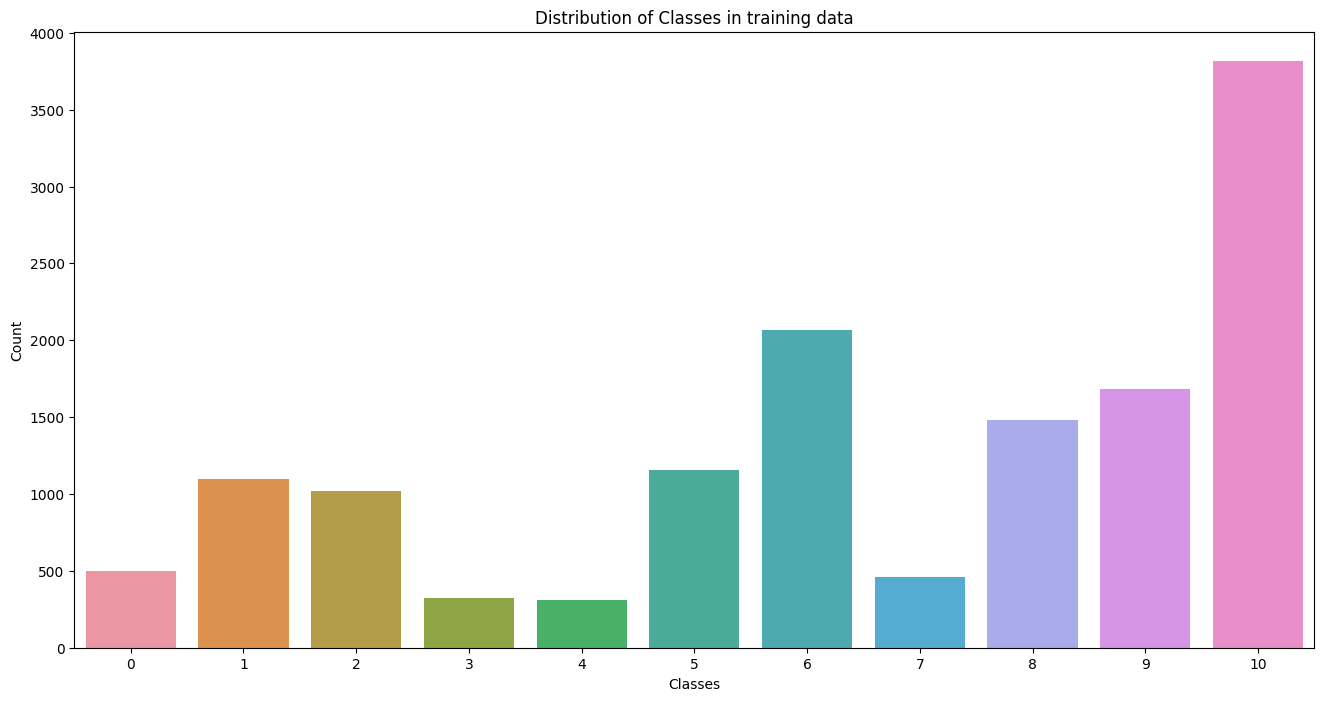

In [162]:
# The distribution of each class (output)
plt.figure(figsize=(16, 8))
# Use countplot to plot the distribution of the 'Class' column
sns.countplot(x=data_train['Class'])
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Distribution of Classes in training data')
# plt.savefig(REPORTS_PATH / "class_distribution.png")
plt.show()

## 2. Song composed by the SAME ARTIST - the SAME GENRE ?

In [163]:
# Count number songs of each artist
total_songs_per_artist = data_train.groupby(['Artist Name']).size().reset_index(name='total_songs')
# Count number songs per class of each artist
artist_stats = data_train.groupby(['Artist Name', 'Class']).size().reset_index(name='song_count')
# Concatenate them and calculate percent
artist_profile = pd.merge(artist_stats, total_songs_per_artist, on='Artist Name')
artist_profile['percentage'] = ((artist_profile['song_count'] / artist_profile['total_songs']) * 100)

# Show, filter: songs > 5
top_artists = artist_profile[artist_profile['total_songs'] > 5].sort_values(
    by=['total_songs', 'percentage'],
    ascending=[False, False]
)

top_artists.head(20)

,Artist Name,Class,song_count,total_songs,percentage
5858,Omer Adam,9,39,39,100.000000
2574,Eyal Golan,9,38,38,100.000000
7034,Shlomo Artzi,10,31,32,96.875000
7033,Shlomo Artzi,9,1,32,3.125000
503,Arik Einstein,10,29,29,100.000000
2244,Dudu Aharon,9,29,29,100.000000
3219,Hadag Nahash,5,27,29,93.103448
3220,Hadag Nahash,9,1,29,3.448276
3221,Hadag Nahash,10,1,29,3.448276
3607,Itay Levi,9,27,27,100.000000


- Comment:
  + Almost: **EACH ARTIST - EACH GENRE**

In [164]:
data_train = data_train.drop('duration_sec', axis=1)
data_train.head(10)

,Id,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,1,Marina Maximilian,Not Afraid,37.0,0.334,0.536,9.0,-6.649,0,0.0381,0.378000,NaN,0.1060,0.2350,152.429,204947.000000,4,9
1,2,The Black Keys,Howlin' for You,67.0,0.725,0.747,11.0,-5.545,1,0.0876,0.027200,0.046800,0.1040,0.3800,132.921,191956.000000,4,6
2,3,Royal & the Serpent,phuck u,NaN,0.584,0.804,7.0,-6.094,1,0.0619,0.000968,0.635000,0.2840,0.6350,159.953,161037.000000,4,10
3,4,Detroit Blues Band,Missing You,12.0,0.515,0.308,NaN,-14.711,1,0.0312,0.907000,0.021300,0.3000,0.5010,172.472,298093.000000,3,2
4,5,Coast Contra,My Lady,48.0,0.565,0.777,6.0,-5.096,0,0.2490,0.183000,NaN,0.2110,0.6190,88.311,254145.000000,4,5
5,6,Beck,Fuckin With My Head (Mountain Dew Rock),38.0,0.657,0.813,7.0,-7.861,1,0.2160,0.008340,0.049200,0.2080,0.5890,82.035,219587.000000,4,10
6,7,Shadow and Light,Blue,11.0,0.658,0.431,1.0,-12.718,0,0.0300,0.615000,0.292000,0.0902,0.5280,132.045,3.893933,5,0
7,8,Within The Ruins,Devil In Me,45.0,0.441,0.994,7.0,-2.934,1,0.2390,0.000073,0.000147,0.3820,0.0478,139.931,213125.000000,4,8
8,9,Crazy Cavan,My Little Sister Gotta Motorbike,38.0,0.446,0.816,9.0,-9.762,1,0.0766,0.318000,NaN,0.3390,0.7180,183.696,165293.000000,4,10
9,10,Day Sulan,Bailar,58.0,0.852,0.535,7.0,-5.940,0,0.0896,0.439000,0.000082,0.2460,0.4830,103.007,205056.000000,4,5


### 3. Data processing and Model building

In [165]:
y_train = data_train['Class']
X_train = data_train.drop('Class', axis=1)
X_train = data_train.drop('Id', axis=1)

# X_train.head(10)
y_train.head(10)

0     9
1     6
2    10
3     2
4     5
5    10
6     0
7     8
8    10
9     5
Name: Class, dtype: int64

##### Pipeline + GridSearchCV -> Save model
- Numeric: 
    +  We have 3 features having missing values (numerical):
        +  instrumentalness (-> fill with 0),
        +  popularity (-> fill with Median),
        +  key (-> fill with mode)
    + Transformation:  log transformation, RobustScaler and StandardScaler
- Categorical : one-hot encoded
  
- Handle imbalanced:  'class_weight'



In [166]:
# from sklearn.base import BaseEstimator, TransformerMixin

class Log1pTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        return np.log1p(X)
        
    def get_feature_names_out(self, input_features=None):
        # help Pipeline know input feature names
        return input_features

In [167]:
#--- FEATURES ---#
# Fill with 0
cols_zero_impute = ['instrumentalness']

# Log Transform + RobustScaler: for features have many outliers, skewed,...
cols_log_robust = ['duration_in min/ms', 'speechiness']
cols_robust_only = ['loudness']

# Median Impute + StandardScaler
cols_standard = ['Popularity', 'tempo', 'acousticness', 'danceability', 'energy', 'liveness', 'valence']

# Categorical:
cols_categorical = ['key', 'mode', 'time_signature']


#--- PIPELINE for features---#
pipe_zero = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

pipe_log_robust = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    # ('log_transform', FunctionTransformer(np.log1p, validate=False)), # Log(1+x)
    ('log_transform', Log1pTransformer()), # Log(1+x)
    ('scaler', RobustScaler())
])
pipe_robust_only  = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

pipe_standard = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

pipe_cat = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('zero_pipe', pipe_zero, cols_zero_impute),
        ('log_pipe', pipe_log_robust, cols_log_robust),
        ('robust_pipe', pipe_robust_only, cols_robust_only), 
        ('std_pipe', pipe_standard, cols_standard),
        ('cat_pipe', pipe_cat, cols_categorical)
    ],
    verbose_feature_names_out=False # beautiful name
)

In [168]:
# N_FEATURE_SELECTED = 10
# pipeline = Pipeline([
#     ('preprocess', preprocessor),
#     ('selector', SelectKBest(f_classif, k=N_FEATURE_SELECTED)), # 10 features
#     ('model', LogisticRegression(max_iter=1000))
# ])


# # Show data after processing
# X_original = X_train.copy()

# X_after_preprocess = pipeline.named_steps['preprocess'].fit_transform(X_original)
# feature_names = (
#     pipeline.named_steps['preprocess'].get_feature_names_out()
# )
# X_after_preprocess_df = pd.DataFrame(
#     X_after_preprocess,
#     columns=feature_names
# )
# X_after_preprocess_df.head(10)

In [169]:
# Run thX_after_preprocesse preprocess to check the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
# Get features name
feature_names = preprocessor.get_feature_names_out()
# To DataFrame
df_preprocessed = pd.DataFrame(X_train_preprocessed, columns=feature_names)

print(f"Shape: {df_preprocessed.shape}")
df_preprocessed.head(10)


Shape: (13914, 28)


,instrumentalness,duration_in min/ms,speechiness,loudness,Popularity,tempo,acousticness,danceability,energy,liveness,...,key_8.0,key_9.0,key_10.0,key_11.0,mode_0.0,mode_1.0,time_signature_1.0,time_signature_3.0,time_signature_4.0,time_signature_5.0
0,-0.496577,-0.075683,-0.193179,0.089164,-0.426139,0.999058,0.416009,-1.251054,-0.528240,-0.569102,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,-0.328439,-0.242442,0.815761,0.339959,1.353307,0.341241,-0.704405,1.107566,0.359474,-0.582057,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1.784781,-0.689691,0.297797,0.215243,-0.070249,1.252770,-0.788187,0.257015,0.599283,0.583856,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,-0.420053,0.878380,-0.337626,-1.742276,-1.909010,1.674915,2.105572,-0.159212,-1.487477,0.687493,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,-0.496577,0.472209,3.812817,0.441958,0.226325,-1.163026,-0.206798,0.142402,0.485690,0.111014,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5,-0.319817,0.100019,3.232845,-0.186165,-0.366824,-1.374655,-0.764641,0.697371,0.637148,0.091582,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6,0.552488,-27.177128,-0.362846,-1.289527,-1.968325,0.311701,1.172959,0.703404,-0.969994,-0.671443,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7,-0.496049,0.023955,3.638702,0.933099,0.048380,0.577620,-0.791047,-0.605600,1.398647,1.218631,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
8,-0.496577,-0.623264,0.595579,-0.618015,-0.366824,2.053393,0.224376,-0.575439,0.649770,0.940107,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
9,-0.496283,-0.074329,0.855555,0.250227,0.819474,-0.667471,0.610835,1.873665,-0.532447,0.337719,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [170]:
# X_train_processed = preprocessor.fit_transform(X_train)

# feature_names = preprocessor.get_feature_names_out()

# df_processed_view = pd.DataFrame(X_train_processed, columns=feature_names)

# print(df_processed_view.head())

In [171]:
MODEL_RANDOM_STATE = 21
model_configs = [
    {
        'name': 'RandomForest',
        'model': RandomForestClassifier(class_weight='balanced', random_state=MODEL_RANDOM_STATE),
        'params': {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [10, 16, 20, None],
            'model__min_samples_leaf': [1, 4]
        }
    },
    {
        'name': 'LogisticRegression',
        'model': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=MODEL_RANDOM_STATE),
        'params': {
            'model__C': [0.1, 1.0, 10.0],
            'model__solver': ['lbfgs', 'liblinear']
        }
    },
    {
        'name': 'XGBClassifier',
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'params':{
            "model__n_estimators": [100, 200, 300],
            "model__learning_rate": [0.01, 0.05, 0.1],
            "model__max_depth": [1, 4, 5, 7, 9]
        }
    }
    # {
    #     'name': 'SVM',
    #     'model': SVC(class_weight='balanced', probability=True, random_state=MODEL_RANDOM_STATE),
    #     'params': {
    #         'model__C': [0.1, 1, 10],
    #         'model__kernel': ['rbf'] 
    #     }
    # }
]

In [172]:
results = []
best_overall_model = None
best_overall_score = -1

for config in model_configs: 
    print(f"{config['name']} is running")

    # Create pipeline: preprocessor -> model
    full_pipeline = Pipeline([
        ('preprocess', preprocessor),
        ('model', config['model'])
    ])

    # GridSearchCV
    grid = GridSearchCV(
        full_pipeline,
        config['params'],
        cv=5,
        scoring={
            'f1': 'f1_weighted',
            'accuracy': 'accuracy',
            # 'roc_auc': 'roc_auc'
        },
        refit='f1', # use 'f1' metric to choose best model
        # Using all CPU 
        n_jobs=-1, # number of threads run in paralell 
        # verbose: 0-quite, 1-short, 2-detail
        verbose=1, # print detail log
        error_score='raise'  # stacktrace chi tiết
    )
    
    grid.fit(X_train, y_train)

    # Save the result
    results.append({
        'Model': config['name'],
        'Best Score': grid.best_score_,
        'Best Params': grid.best_params_
    })

    print(f"Best score of {config['name']}: {grid.best_score_:.4f}")

    # Update global best model
    if grid.best_score_ > best_overall_score:
        best_overall_score = grid.best_score_
        best_overall_model = grid.best_estimator_

    

RandomForest is running
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best score of RandomForest: 0.5011
LogisticRegression is running
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best score of LogisticRegression: 0.4638
XGBClassifier is running
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best score of XGBClassifier: 0.5278


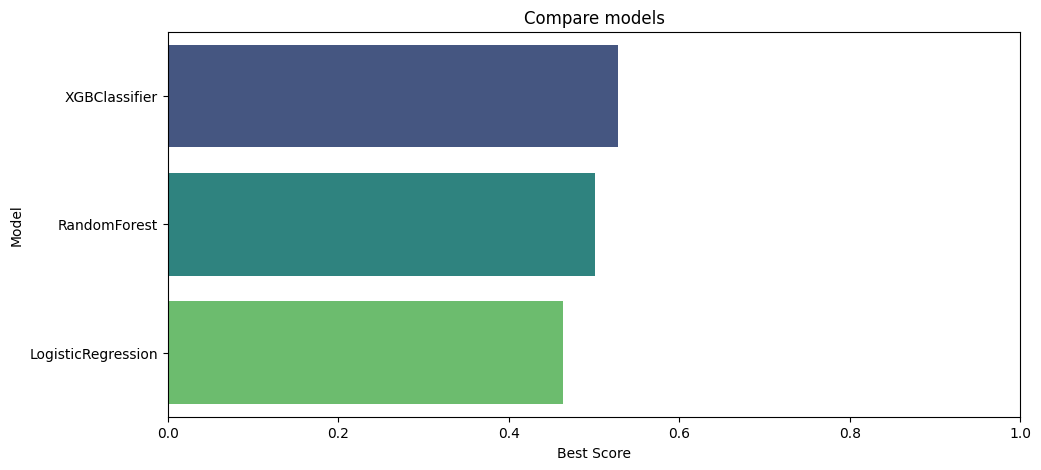

                Model  Best Score  \
2       XGBClassifier    0.527810   
0        RandomForest    0.501148   
1  LogisticRegression    0.463839   

                                         Best Params  
2  {'model__learning_rate': 0.1, 'model__max_dept...  
0  {'model__max_depth': 16, 'model__min_samples_l...  
1   {'model__C': 10.0, 'model__solver': 'liblinear'}  


In [173]:
# Compare model
results_df = pd.DataFrame(results).sort_values(
    by='Best Score',
    ascending=False
)

# Draw compared plot
plt.figure(figsize=(11, 5))
sns.barplot(data=results_df, x='Best Score', y='Model', palette='viridis')
plt.title('Compare models')
plt.xlim(0, 1.0)
plt.show()

print(results_df)

In [174]:



# Save the model -> [name].pkl
print(f"Best model: {results_df.iloc[0]['Model']}")

print("Saving best model...")

joblib.dump(best_overall_model, f"V1_baseline_best_model_MusicGenre{formatted_current_datetime}.pkl")

print(f"\n->_<- Saved V1_baseline_best_model_MusicGenre{formatted_current_datetime}.pkl\n")


Best model: XGBClassifier
Saving best model...

->_<- Saved V1_baseline_best_model_MusicGenre2025-11-21_08:39:05.pkl



## Predict


In [175]:
model_filename = 'V1_baseline_best_model_MusicGenre2025-11-21_07:52:35.pkl'
# Load model
model_pred = joblib.load(model_filename)

print(f'Loaded model successfully; {model_filename}')


Loaded model successfully; V1_baseline_best_model_MusicGenre2025-11-21_07:52:35.pkl


In [176]:
data_test_id = data_test['Id']
X_test = data_test.drop(['Id'], axis=1)

y_pred = model_pred.predict(X_test)
print("Đã dự đoán thành công!")

# Create submission DataFrame
submission = pd.DataFrame({
    "Id": data_test_id,
    "Class": y_pred
})

# Save to CSV
submission.to_csv("submission.csv", index=False)
print("[DONE] Submission file saved as submission.csv")


AttributeError: 'NoneType' object has no attribute 'predict'